# K-Nearest Neighbors (KNN): Theory & Application

## 1) The Theory: Finding the Nearest Neighbors

The K-nearest neighbors algorithm uses the following steps to classify a given prediction:

1. **Compute the Distance**:
   Decide on a distance metric (e.g., Euclidean distance) beforehand. For each data point *i* in the training set, calculate the distance between the test point and every feature vector *j*:
   $$d(x_{\text{test}}, x_i) = \sqrt{\sum_{j=1}^n (x_{\text{test}, j} - x_{i, j})^2} = \| x_{\text{test}} - x_i \|_2$$
   where:
   - *$x_{\text{test}}$* is the test point.
   - *$x_{\text{i}}$* is a training point.
   - *j* is a feature.
   - *n* is the number of features.

2. **Repeat for All Points**:
   Perform the distance calculation for all \(i\) points in the training dataset.

3. **Calculate Conditional Probabilities**:
   For each class label \(y\), calculate the conditional probability that the test point belongs to that label given the \(k\)-nearest neighbors:
   $$P(y = j \mid \text{neighbors}) = \frac{1}{k} \sum_{i=1}^k \mathbb{I}(y_i = j)$$
   where:
   - $\mathbb{I}(y_i = j)$ is the indicator function, which equals 1 if $y_i = j$ (the neighbor belongs to class *j* and 0 otherwise.
   - *k* is the number of neighbors.

4. **Choose the Label with Maximum Probability**:
   Select the label *j* that maximizes the conditional probability:
   $$\hat{y} = \arg\max_{j} P(y = j \mid \text{neighbors})$$
   The test point is assigned the class label corresponding to the highest conditional probability.


### Let's go through a basic classification example.

In [41]:
import numpy as np
import pandas as pd

**We'll gather some data and split between features and labels.**

In [42]:
features = [[1, 2], [3, 4], [5, 6]]
labels = [1, 2, 1]

# Convert features list to numpy array and create DataFrame
features_array = np.array(features)
df = pd.DataFrame(features_array, columns=['feature1', 'feature2'])

# Add labels column
df['label'] = labels
print(df)

   feature1  feature2  label
0         1         2      1
1         3         4      2
2         5         6      1


**Specify our test point for classification.**

In [43]:
x_test = np.array([10, 12])

**Find the euclidean distance between that point with all other points and each of their features.**

In [44]:
features = df.drop('label', axis=1)
for i in range(len(df)):
    dist = np.linalg.norm(x_test-features.iloc[i])
    df.loc[i, 'dist'] = dist 
    
print(df)

   feature1  feature2  label       dist
0         1         2      1  13.453624
1         3         4      2  10.630146
2         5         6      1   7.810250


**We'll specify the "k" in k-nearest neighbors to decide *which* neighbors we should use for our algorithm.**

In [28]:
k = 1

# We are taking the highest 1 data point for classification

**Finally, we alculate and choose the label with the maximum (conditional) probability as our classification.**

In [52]:
# First sort the dataframe by distance to get nearest neighbor
df_sorted = df.sort_values('dist')

# For k=1, we only look at the first row (nearest neighbor)
nearest_label = df_sorted.iloc[0]['label']

# Create indicator function
def indicator(nearest_label):
    label_1 = 0  # Use integers instead of lists
    label_2 = 0
    
    if nearest_label == 1:
        label_1 = 1
    elif nearest_label == 2:
        label_2 = 1
        
    return {1: label_1, 2: label_2}  # Return a dictionary mapping labels to counts

# Get the counts
label_counts = indicator(nearest_label)

# Find the label with maximum count
classification = max(label_counts, key=label_counts.get)

print(f"Label counts: {label_counts}")
print(f"Classification: {classification}")

Label counts: {1: 1, 2: 0}
Classification: 1


### Our point should be classified with the label "1" according to KNN.

## 2) The Application: Diagnosing Breast Cancer

In [55]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rahmasleam/breast-cancer")

print("Path to dataset files:", path)

100%|██████████| 48.6k/48.6k [00:00<00:00, 14.7MB/s]

Extracting files...
Path to dataset files: /Users/alexdubro/.cache/kagglehub/datasets/rahmasleam/breast-cancer/versions/1


In [80]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [60]:
dataset_path = os.path.join(path, 'breast-cancer.csv')

raw_data = pd.read_csv(dataset_path)
raw_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


We know that M is "Malignant" and B is "Benign." Let's turn those into our label by assigning:
- M = 1
- B = 0

In [62]:
raw_data['diagnosis'] = raw_data['diagnosis'].replace({'M': 1, 'B': 0})

/var/folders/k3/r6qtx6ps7r9312vkvx9ynl8c0000gn/T/ipykernel_45674/925139889.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raw_data['diagnosis'] = raw_data['diagnosis'].replace({'M': 1, 'B': 0})


Let's split the dataset up into training and test. The training set can be used to predict each test point, as we saw in the theory. Since KNN is an instance-based algorithm, the test points will be evaluated on a case-by-case basis.

In [67]:
features = raw_data.drop(['diagnosis'], axis=1)
label = raw_data['diagnosis']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=10)

Because of the sheer difference in size between each column's values (i.e. one column's values might be in thousands; another in decimals), let's standardize the values.

In [69]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Now, let's run KNN, and we'll have k be variable.

In [78]:
def evaluate_knn(X_train, X_test, y_train, y_test, max_k=30):
    train_scores = []
    test_scores = []
    
    for k in range(1, max_k + 1):
        # Create and train KNN classifier
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Calculate scores
        train_score = knn.score(X_train, y_train)
        test_score = knn.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    return train_scores, test_scores

# Perform evaluation
train_scores, test_scores = evaluate_knn(X_train, X_test, y_train, y_test)

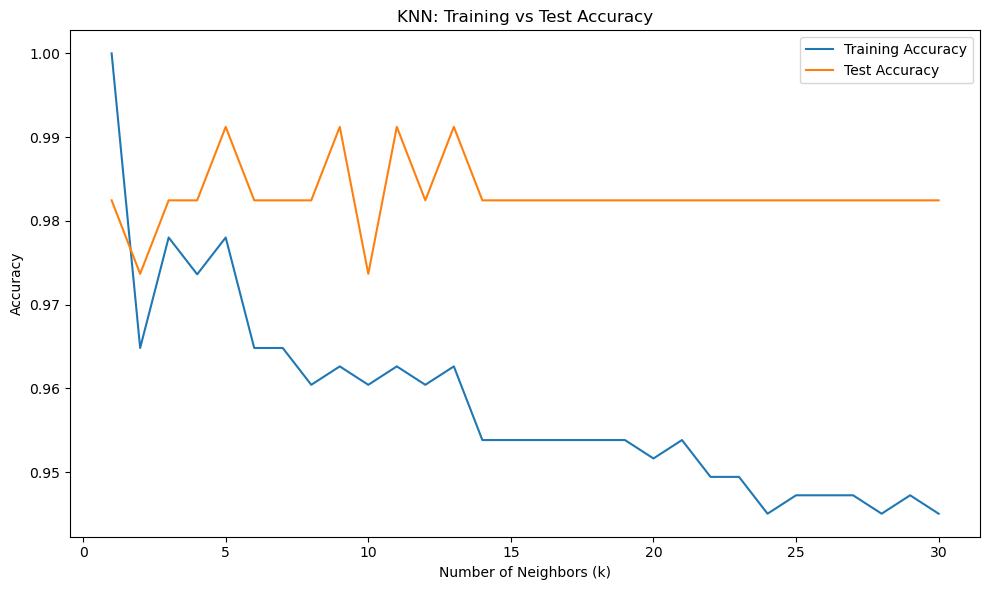

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), train_scores, label='Training Accuracy')
plt.plot(range(1, 31), test_scores, label='Test Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN: Training vs Test Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

Our KNN tells us how accurately our training and test sets did in predicting the algorithm. What matters just as much is how closely those two results are. Let's find out.

In [77]:
# Find the differences between train and test scores
differences = [abs(train - test) for train, test in zip(train_scores, test_scores)]

# Find the k value (adding 1 since k starts at 1) where difference is smallest
best_k = differences.index(min(differences)) + 1

print(f"Best k: {best_k}")
print(f"Train score: {train_scores[best_k-1]:.4f}")
print(f"Test score: {test_scores[best_k-1]:.4f}")
print(f"Difference: {differences[best_k-1]:.4f}")

Best k: 3
Train score: 0.9780
Test score: 0.9825
Difference: 0.0044


Let's evaluate how well our algorithm did.

In [ ]:
# Multiple train-test splits to get more robust evaluation
def robust_knn_evaluation(X, y, n_splits=10):
    # Use StratifiedKFold to ensure each fold maintains class distribution
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    results = []
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Try different k values
        best_k = 0
        best_score = 0
        
        for k in range(1, min(11, len(X_train))):
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            score = knn.score(X_test, y_test)
            
            if score > best_score:
                best_score = score
                best_k = k
        
        # Evaluate with best k
        knn = KNeighborsClassifier(n_neighbors=best_k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        results.append({
            'best_k': best_k,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='macro'),
            'recall': recall_score(y_test, y_pred, average='macro'),
            'f1': f1_score(y_test, y_pred, average='macro')
        })
    
    # Aggregate results
    print("Evaluation Across Multiple Splits:")
    print("Best k values:", [r['best_k'] for r in results])
    print("Accuracies:", [r['accuracy'] for r in results])
    print("\nAverage Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        values = [r[metric] for r in results]
        print(f"{metric.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")

# Run the evaluation
robust_knn_evaluation(X_scaled, y)

##  Algorithm: Classifying the data point

In [7]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Function to perform cross-validation for different k values
def find_best_k(X, y, max_k=20):
    k_values = []
    cv_scores = []
    
    for k in range(1, max_k + 1):
        # Create KNN classifier
        knn = KNeighborsClassifier(n_neighbors=k)
        
        # Perform cross-validation
        scores = cross_val_score(knn, X, y, cv=5)
        
        # Store results
        k_values.append(k)
        cv_scores.append(scores.mean())
    
    # Find the k with the highest cross-validation score
    best_k = k_values[np.argmax(cv_scores)]
    best_score = max(cv_scores)
    
    return k_values, cv_scores, best_k, best_score

# Find the best k
k_values, cv_scores, best_k, best_score = find_best_k(X, y)

# Print results
print("K Values:", k_values)
print("Cross-Validation Scores:", cv_scores)
print(f"Best K: {best_k}")
print(f"Best Cross-Validation Score: {best_score:.4f}")

# Demonstrate final model with best k
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
print(f"Test Score with Best K: {best_knn.score(X_test, y_test):.4f}")

K Values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Cross-Validation Scores: [np.float64(0.96), np.float64(0.9466666666666665), np.float64(0.9666666666666668), np.float64(0.9733333333333334), np.float64(0.9733333333333334), np.float64(0.9800000000000001), np.float64(0.9800000000000001), np.float64(0.9666666666666668), np.float64(0.9733333333333334), np.float64(0.9800000000000001), np.float64(0.9800000000000001), np.float64(0.9800000000000001), np.float64(0.9733333333333334), np.float64(0.9666666666666666), np.float64(0.9666666666666668), np.float64(0.9666666666666668), np.float64(0.9666666666666668), np.float64(0.9666666666666666), np.float64(0.9666666666666668), np.float64(0.96)]
Best K: 6
Best Cross-Validation Score: 0.9800
Test Score with Best K: 1.0000


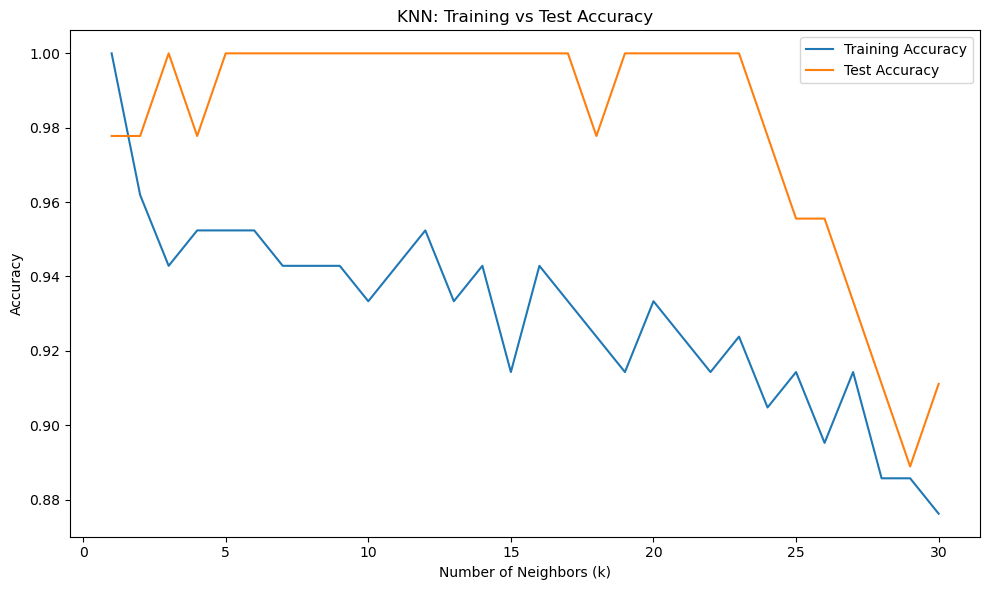

Best k: 3

Model Performance Metrics:
Accuracy: 1.0000
Precision (Macro): 1.0000
Recall (Macro): 1.0000
F1 Score (Macro): 1.0000

Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report
)
from sklearn.preprocessing import StandardScaler

# Load and preprocess data
iris = load_iris()
X, y = iris.data, iris.target

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Evaluate different k values
def evaluate_knn(X_train, X_test, y_train, y_test, max_k=30):
    train_scores = []
    test_scores = []
    
    for k in range(1, max_k + 1):
        # Create and train KNN classifier
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Calculate scores
        train_score = knn.score(X_train, y_train)
        test_score = knn.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    return train_scores, test_scores

# Perform evaluation
train_scores, test_scores = evaluate_knn(X_train, X_test, y_train, y_test)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), train_scores, label='Training Accuracy')
plt.plot(range(1, 31), test_scores, label='Test Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN: Training vs Test Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Find best k
best_k = test_scores.index(max(test_scores)) + 1
print(f"Best k: {best_k}")

# Detailed model evaluation with best k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

# Print comprehensive metrics
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision (Macro): {precision_score(y_test, y_pred, average='macro'):.4f}")
print(f"Recall (Macro): {recall_score(y_test, y_pred, average='macro'):.4f}")
print(f"F1 Score (Macro): {f1_score(y_test, y_pred, average='macro'):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

## Evaluating the Algorithm: Measuring how well the algorithm does

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report
)
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Load and preprocess data
iris = load_iris()
X, y = iris.data, iris.target

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Multiple train-test splits to get more robust evaluation
def robust_knn_evaluation(X, y, n_splits=10):
    # Use StratifiedKFold to ensure each fold maintains class distribution
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    results = []
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Try different k values
        best_k = 0
        best_score = 0
        
        for k in range(1, min(11, len(X_train))):
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            score = knn.score(X_test, y_test)
            
            if score > best_score:
                best_score = score
                best_k = k
        
        # Evaluate with best k
        knn = KNeighborsClassifier(n_neighbors=best_k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        results.append({
            'best_k': best_k,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='macro'),
            'recall': recall_score(y_test, y_pred, average='macro'),
            'f1': f1_score(y_test, y_pred, average='macro')
        })
    
    # Aggregate results
    print("Evaluation Across Multiple Splits:")
    print("Best k values:", [r['best_k'] for r in results])
    print("Accuracies:", [r['accuracy'] for r in results])
    print("\nAverage Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        values = [r[metric] for r in results]
        print(f"{metric.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")

# Run the evaluation
robust_knn_evaluation(X_scaled, y)

Evaluation Across Multiple Splits:
Best k values: [1, 1, 2, 1, 4, 1, 1, 1, 1, 7]
Accuracies: [1.0, 1.0, 1.0, 0.9333333333333333, 0.9333333333333333, 0.8666666666666667, 1.0, 1.0, 1.0, 0.9333333333333333]

Average Metrics:
Accuracy: 0.9667 ± 0.0447
Precision: 0.9738 ± 0.0339
Recall: 0.9667 ± 0.0447
F1: 0.9659 ± 0.0461
